In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl 
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm

## Implementating NMF - Non-negative Matrix Factorization using Neural Networks

In [44]:
# load dataset
dataset = fetch_olivetti_faces(shuffle=False, random_state=42)

In [45]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=42)

In [46]:
# convert to torch tensor
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# normalize
X_train = X_train.float() / 255
X_test = X_test.float() / 255

# reshape
X_train = X_train.view(-1, 1, 64, 64)
X_test = X_test.view(-1, 1, 64, 64)

# check shape
print(X_train.shape)

torch.Size([320, 1, 64, 64])


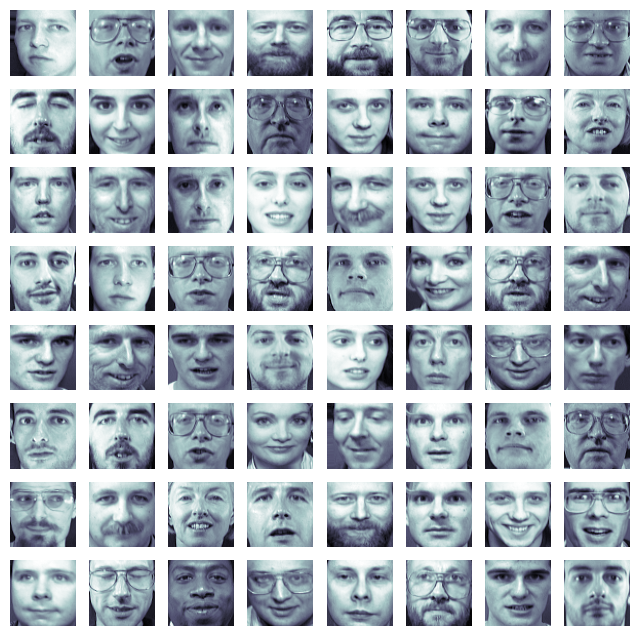

In [47]:
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i][0], cmap='bone')
    axi.axis('off')

In [48]:
class DeepNMF(nn.Module):
    def __init__(self, n_components=64):
        super().__init__()
        self.W = None
        self.H = None
        self.l1 = nn.Linear(4096, n_components)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = X.view(-1, 4096)
        self.H = self.relu(self.l1(X))
        self.W = self.l1.weight.clamp(min=0)
        
        return self.W, self.H

In [49]:
def frobenius_norm(target, op):
    return torch.sqrt(torch.sum(torch.square(target - op)))

In [50]:
model = DeepNMF(144)
criterion = frobenius_norm
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
n_epochs = 5000

In [52]:
losses = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    W, H = model(X_train)
    loss = criterion(X_train, torch.matmul(H,W).reshape(-1, 1, 64, 64))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    # print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, n_epochs, loss.item()))

100%|██████████| 5000/5000 [03:28<00:00, 24.03it/s]


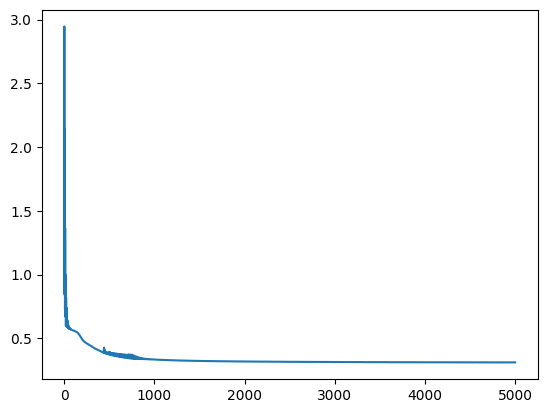

In [53]:
plt.plot(losses);

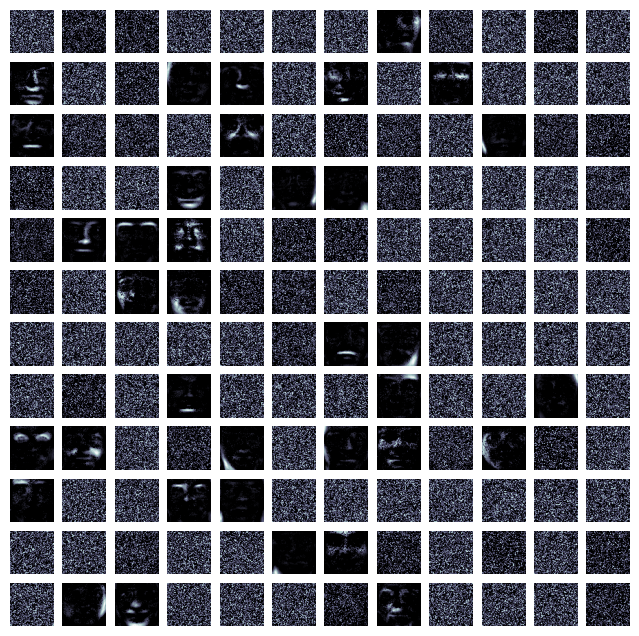

In [54]:
# plot the features
fig, ax = plt.subplots(12, 12, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(model.W.detach().numpy()[i].reshape(64, 64), cmap='bone')
    axi.axis('off')

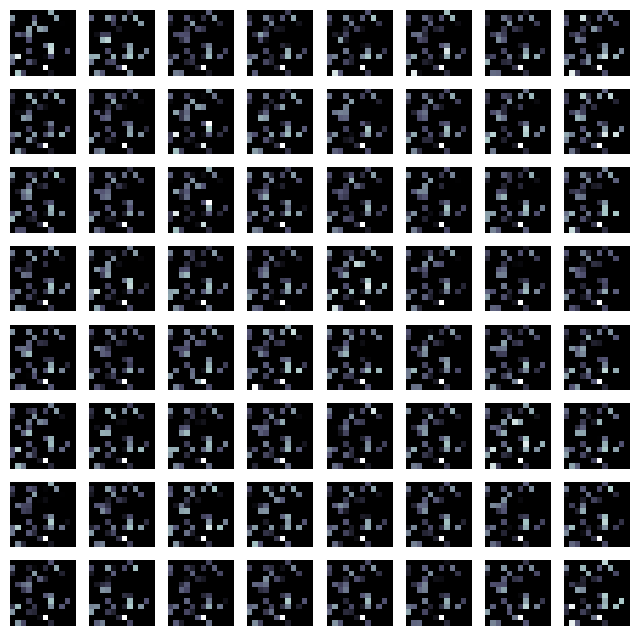

In [55]:
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(model.H.detach().numpy()[i].reshape(12, 12), cmap='bone')
    axi.axis('off')

In [56]:
output = torch.matmul(model.H, model.W).reshape(-1, 1, 64, 64)

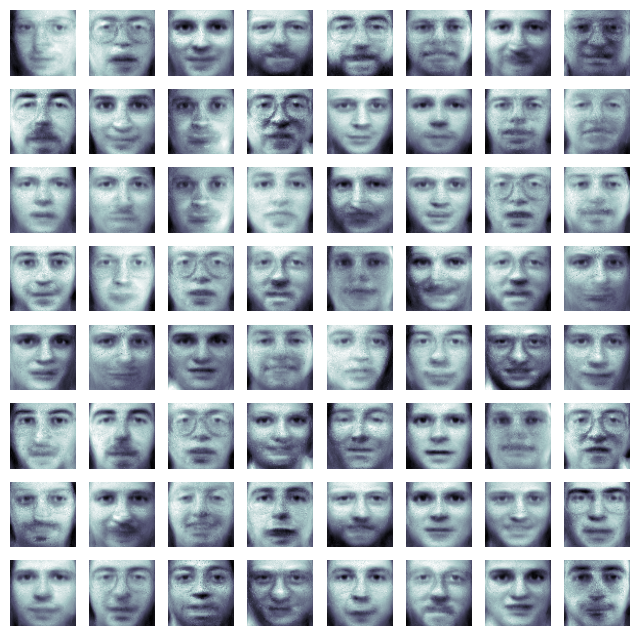

In [57]:
# plot the reconstructions
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(output.detach().numpy()[i].reshape(64, 64), cmap='bone')
    axi.axis('off')

### Testing on unseen

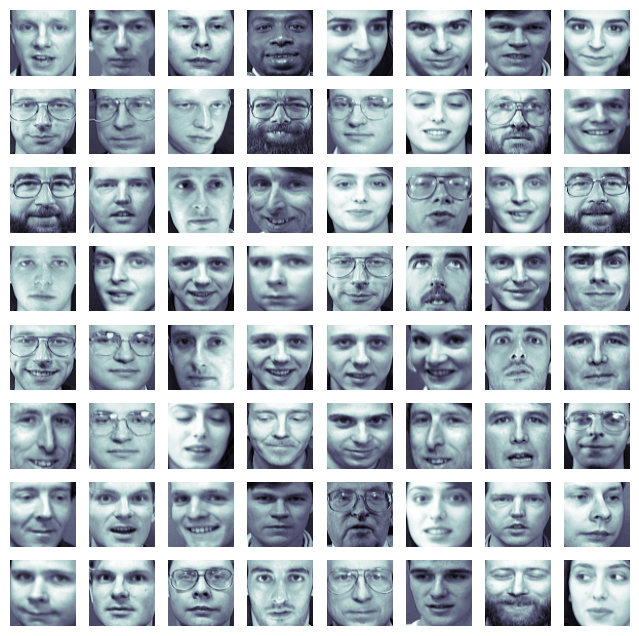

In [58]:
# show the test images
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i][0], cmap='bone')
    axi.axis('off')

In [59]:
W, H = model(X_test)
output_test = torch.matmul(model.H, model.W).reshape(-1, 1, 64, 64)

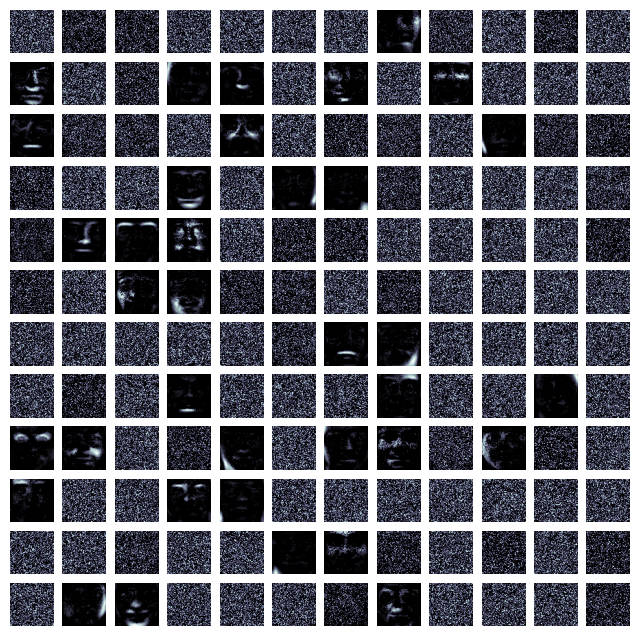

In [60]:
# plot the reconstructions
fig, ax = plt.subplots(12, 12, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(model.W.detach().numpy()[i].reshape(64, 64), cmap='bone')
    axi.axis('off')

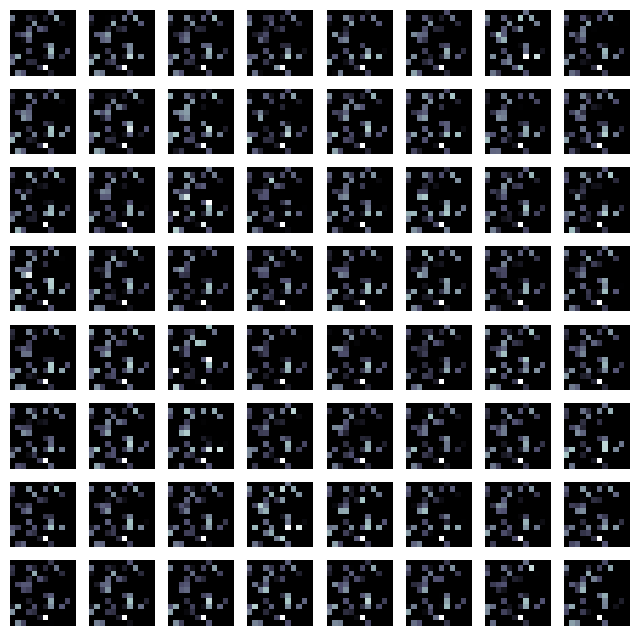

In [61]:
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(model.H.detach().numpy()[i].reshape(12, 12), cmap='bone')
    axi.axis('off')

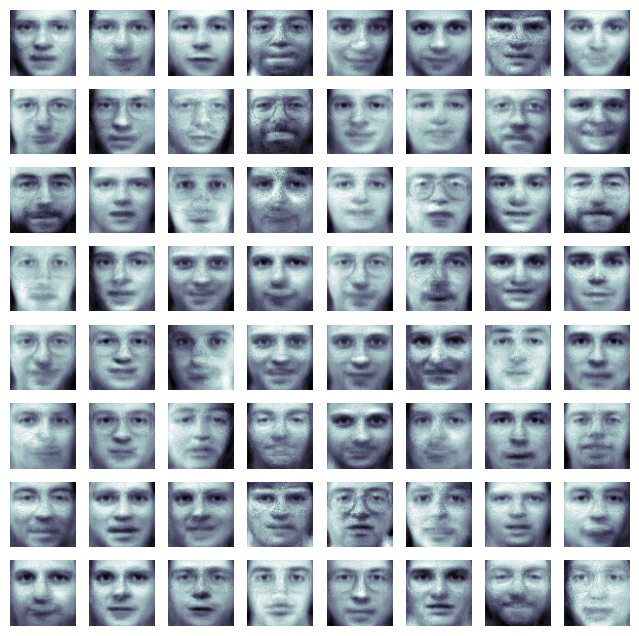

In [62]:
# plot the reconstructions
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(output_test.detach().numpy()[i].reshape(64, 64), cmap='bone')
    axi.axis('off')

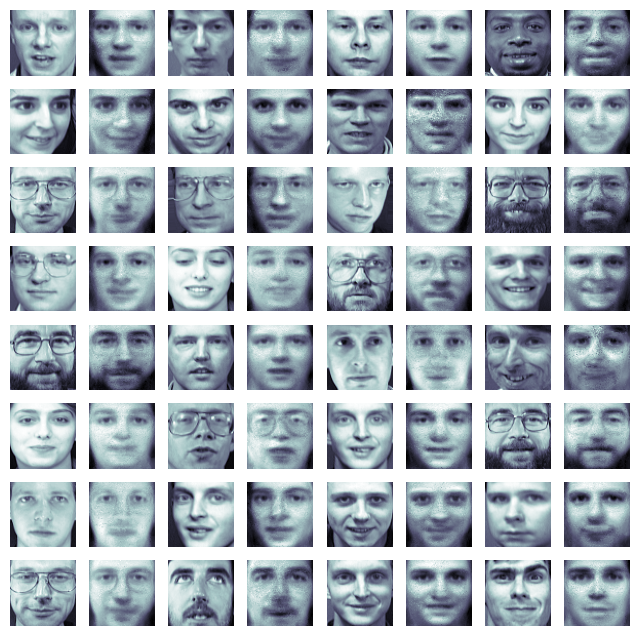

In [63]:
# compare test and reconstruction side-by-side
fig, ax = plt.subplots(8, 8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    if i%2 == 0:
        axi.imshow(X_test[i//2][0], cmap='bone')
    else:
        axi.imshow(output_test.detach().numpy()[i//2].reshape(64, 64), cmap='bone')
    axi.axis('off')
